# Defining the questions
Q.1   Analyze which genres have the highest and the lowest average rating

Q.2   Analyze genre combinations make a successful

# Collecting and cleaning the data

IMDb Dataset:
https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset

title.basics.tsv.gz - Contains the following information for titles:
* tconst (string) - alphanumeric unique identifier of the title.
* titleType (string) – the type/format of the title (e.g. movie, short,
tvseries, tvepisode, video, etc).
* genres (string array) – includes up to three genres associated with
the title.

https://drive.google.com/file/d/1zys9QZjgjA_6kSg9EWd5RdNAJ13lDs2p/view?usp=sharing

title.ratings.tsv.gz – Contains the IMDb rating and votes information for titles:
* tconst (string) - alphanumeric unique identifier of the title.
* averageRating – weighted average of all the individual user ratings.
* numVotes - number of votes the title has received.

https://drive.google.com/file/d/1cszDgIoziE05bgcTN4oYDLWqDEWCWfPv/view?usp=sharing

In [1]:
! gdown 1zys9QZjgjA_6kSg9EWd5RdNAJ13lDs2p

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1zys9QZjgjA_6kSg9EWd5RdNAJ13lDs2p 



"basics" table is over 100 MB, so it can't be download with gdown. You have to mount Google Drive into notebook.

In [2]:
! unzip /content/drive/MyDrive/Datasets/title_basics.zip

Archive:  /content/drive/MyDrive/Datasets/title_basics.zip
  inflating: title_basics.tsv        n



In [3]:
! gdown 1cszDgIoziE05bgcTN4oYDLWqDEWCWfPv

Downloading...
From: https://drive.google.com/uc?id=1cszDgIoziE05bgcTN4oYDLWqDEWCWfPv
To: /content/title_ratings.zip
100% 6.47M/6.47M [00:00<00:00, 122MB/s]


In [4]:
! unzip /content/title_ratings.zip

Archive:  /content/title_ratings.zip
  inflating: title_ratings.tsv       


In [38]:
import pandas as pd
import seaborn as sns

Parse the files.

From basics we keep only movies and relevant fields.

In [6]:
fields = ['tconst', 'titleType', 'primaryTitle', 'startYear', 'genres']
basics = pd.read_table('/content/title_basics.tsv', usecols=fields)[lambda row: row['titleType'] == 'movie']     

In [7]:
basics.head()

,tconst,titleType,primaryTitle,startYear,genres
8,tt0000009,movie,Miss Jerry,1894,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,1897,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,1905,\N
570,tt0000574,movie,The Story of the Kelly Gang,1906,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,1907,Drama


Parse ratings table

In [8]:
ratings = pd.read_table('/content/title_ratings.tsv')    

In [9]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1949
1,tt0000002,5.8,264
2,tt0000003,6.5,1782
3,tt0000004,5.6,179
4,tt0000005,6.2,2583


# Process

Merge "basics" table with "ratings" table into one "df" table

In [10]:
df = basics.merge(ratings, on='tconst', how='left')
df

,tconst,titleType,primaryTitle,startYear,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,1894,Romance,5.3,204.0
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,1897,"Documentary,News,Sport",5.2,466.0
2,tt0000502,movie,Bohemios,1905,\N,4.1,15.0
3,tt0000574,movie,The Story of the Kelly Gang,1906,"Action,Adventure,Biography",6.0,808.0
4,tt0000591,movie,The Prodigal Son,1907,Drama,4.4,20.0
...,...,...,...,...,...,...,...
635044,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,Documentary,NaN,NaN
635045,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,2007,Documentary,NaN,NaN
635046,tt9916706,movie,Dankyavar Danka,2013,Comedy,NaN,NaN
635047,tt9916730,movie,6 Gunn,2017,\N,8.1,9.0


Remove rows without genres or with votes no less than 1000 (from ~560k titles down to ~40k). We copy() because we need a copy, not a view.

In [11]:
min_numVotes = 1000
df = df[(df['genres'] != r'\N') & (df['numVotes'] >= min_numVotes)].copy()

Describe prepared table

In [12]:
df.info()
len(pd.unique(df['genres']))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39236 entries, 132 to 635040
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         39236 non-null  object 
 1   titleType      39236 non-null  object 
 2   primaryTitle   39236 non-null  object 
 3   startYear      39236 non-null  object 
 4   genres         39236 non-null  object 
 5   averageRating  39236 non-null  float64
 6   numVotes       39236 non-null  float64
dtypes: float64(2), object(5)
memory usage: 2.4+ MB


797

No we check genres combinations in order to define broader categories.

In [13]:
df.genres.value_counts().head()

Drama                   3070
Comedy                  1912
Comedy,Drama            1777
Drama,Romance           1592
Comedy,Drama,Romance    1500
Name: genres, dtype: int64

We create a dictionary of genre combinations and map a new column "genre".

In [14]:
#@title Genres Dictionary
#TODO: write a sorting function

genres_dict = {
    'Action': ['Action', 'Action,Adventure,Crime', 'Action,Crime,Drama ', 'Action,Comedy,Crime', 'Action,Crime,Thriller', 'Action,Adventure,Comedy',
               'Action,Adventure,Drama', 'Action,Thriller', 'Action,Drama', 'Action,Adventure,Sci-Fi', 'Action,Adventure,Fantasy',
               'Action,Comedy,Drama','Action,Comedy', 'Action,Drama,History', 'Action,Crime,Drama', 'Action,Biography,Drama',
               'Action,Drama,Thriller', 'Action,Drama,Romance', 'Action,Sci-Fi,Thriller', 'Action,Adventure,Thriller', 'Action,Drama,War',
               'Action,Sci-Fi', 'Action,Adventure', 'Action,Adventure,Family', 'Action,Drama,Sci-Fi', 'Action,Drama,Fantasy', 'Action,Crime,Mystery',
               'Action,Drama,Sport', 'Action,Crime', 'Action,Drama,Mystery', 'Action,Biography,Crime', 'Action,Adventure,Romance'
               'Action,Adventure,Biography', 'Action,Adventure,History', 'Action,Adventure,Mystery', 'Action,Romance', 'Action,Adventure,Romance',
               'Action,Crime,Sci-Fi', 'Action,Western', 'Action,Crime,Sci-Fi', 'Action,Western', 'Drama,Fantasy,Sci-Fi', 'Action,Romance,Thriller',
               'Action,Fantasy,Sci-Fi', 'Action,Mystery,Sci-Fi', 'Action,War', 'Action,Adventure,Western', 'Action,Adventure,Biography',
               'Action,Fantasy,Thriller', 'Action,Drama,Western', 'Action,Crime,Fantasy', 'Action,Thriller,War', 'Action,Fantasy', 'Action,Sport',
               'Action,Adventure,War', 'Action,Drama,Family', 'Action,Fantasy,Romance', 'Action,History,War', 'Action,Crime,Romance',
               'Action,Romance,War', 'Action,Romance,Western', 'Action,Sci-Fi,Sport', 'Action,Sport,Thriller', 'Action,Family,Sci-Fi',
               'Action,History,Thriller', 'Action,Mystery,Romance', 'Action,Romance,Sci-Fi', 'Action,Biography,History', 'Action,Crime,Family',
               'Action,Drama,Film-Noir', 'Action,History', 'Action,Thriller,Western', 'Action,Family,Fantasy', 'Action,Family', 'Action,Crime,Sport',
               'Action,Crime,History', 'Action,Adult,Drama', 'Action,Family,Western', 'Action,Family,Sport', 'Action,Family,Romance',
               'Action,Crime,War', 'Action,Crime,Film-Noir', 'Action,Biography,Western', 'Action,War,Western', 'Action,Mystery,Western',
               'Action,History,Western', 'Action,Fantasy,Western', 'Action,Fantasy,History'],
    
    'Adventure': ['Adventure', 'Adventure,Drama,Fantasy', 'Adventure,Drama,History', 'Adventure,Crime', 'Adventure,Drama',
                  'Adventure,Drama,Family', 'Adventure,Family,Fantasy', 'Adventure,Drama,Romance', 'Adventure,Drama,Family', 'Adventure,Family,Fantasy',
                  'Adventure,Drama,Romance', 'Adventure,Biography,Drama', 'Adventure,Crime,Drama', 'Adventure,Family', 'Adventure,Drama,Western',
                  'Adventure,Fantasy', 'Adventure,Drama,Sci-Fi', 'Adventure,Drama,War', 'Adventure,Drama,Mystery', 'Adventure,Sci-Fi',
                  'Adventure,Western', 'Adventure,Sci-Fi', 'Adventure,Fantasy,Sci-Fi', 'Adventure,Family,Sci-Fi', 'Adventure,History,Romance',
                  'Adventure,Fantasy,Romance', 'Adventure,Drama,Sport', 'Adventure,Mystery,Sci-Fi', 'Adventure,Family,Mystery',
                  'Adventure,History,War', 'Adventure,Family,Romance', 'Adventure,Fantasy,Mystery', 'Adventure,Romance', 'Adventure,Romance,War',
                  'Adventure,Fantasy,History', 'Adventure,War', 'Adventure,Romance,Sci-Fi', 'Adventure,Drama,Film-Noir',
                  'Adventure,Crime,Mystery', 'Adventure,Biography,History', 'Adventure,History', 'Adventure,Biography,Crime',
                  'Adventure,War,Western', 'Adventure,Mystery,War', 'Adventure,Mystery', 'Adventure,Family,War', 'Adventure,Family,Sport',
                  'Adventure,Family,History', 'Adventure,Family,Western', 'Adventure,Film-Noir,Romance', 'Adventure,History,Sci-Fi',
                  'Adventure,Biography,Western', 'Adventure,Biography,War', 'Action,Biography,Thriller', 'Adventure,Biography,Romance'],
    
    'Animation': ['Animation', 'Adventure,Animation,Comedy', 'Action,Adventure,Animation', 'Adventure,Animation,Fantasy',
                  'Adventure,Animation,Family', 'Adventure,Animation,Drama', 'Animation,Comedy,Family', 'Animation,Comedy,Drama',
                  'Action,Animation,Fantasy', 'Action,Animation,Drama', 'Action,Animation,Comedy', 'Animation,Drama,Family',
                  'Action,Animation,Crime', 'Animation,Family,Fantasy', 'Animation,Drama,Fantasy', 'Action,Animation,Sci-Fi',
                  'Animation,Comedy', 'Animation,Biography,Drama', 'Animation,Comedy,Fantasy', 'Animation,Drama', 'Animation,Drama,Romance',
                  'Adventure,Animation,Crime', 'Animation,Fantasy', 'Animation,Comedy,Musical', 'Animation,Drama,Sci-Fi', 'Adventure,Romance,Western',
                  'Adventure,Animation,Sci-Fi', 'Animation,Family', 'Action,Animation,Horror', 'Animation,Drama,History', 'Animation,Biography,Documentary',
                  'Animation,Comedy,Sci-Fi', 'Animation,Drama,Mystery', 'Animation,Documentary', 'Animation,Fantasy,Horror',
                  'Animation,Drama,War',	'Animation,Drama,Music', 'Animation,Drama,Horror', 'Animation,Documentary,History',
                  'Animation,Crime,Drama', 'Animation,Comedy,Crime', 'Action,Animation,Family', 'Animation,Family,Musical', 'Animation,Drama,Thriller',
                  'Animation,Horror,Mystery', 'Animation,Fantasy,Music', 'Animation,Comedy,Music', 'Animation,Comedy,Horror',
                  'Animation,Sci-Fi,Thriller', 'Adventure,Animation,Horror', 'Action,Animation,Mystery', 'Animation,Documentary,Mystery',
                  'Animation,Sci-Fi', 'Animation,Mystery,Sci-Fi', 'Animation,History', 'Animation,Fantasy,Sci-Fi', 
                  'Animation,Fantasy,Myster', 'Animation,Family,History', 'Animation,Drama,Sport', 'Animation,Crime,Mystery',
                  'Animation,Crime,Music', 'Animation,Crime,Documentary', 'Animation,Comedy,Romance', 'Animation,Comedy,Mystery' 
                  'Animation,Comedy,Documentary', 'Animation,Biography,Comedy', 'Animation,Biography', 'Action,Animation,Romance',
                  'Action,Animation,Thriller', 'Animation,Fantasy,Mystery', 'Animation,Comedy,Mystery', 'Animation,Comedy,Documentary',
                  'Adventure,Animation,Mystery', 'Adventure,Animation,Music', 'Adventure,Animation,Biography'],
               
    'Comedy': ['Comedy', 'Comedy,Drama', 'Comedy,Drama,Romance', 'Comedy,Romance', 'Comedy,Crime', 'Comedy,Drama,Family',
              'Comedy,Drama,Fantasy', 'Biography,Comedy,Drama', 'Comedy,Crime,Drama', 'Comedy,Fantasy,Sci-Fi',
               'Comedy,Crime,Romance', 'Crime,Drama', 'Adventure,Comedy,Drama', 'Adventure,Comedy,Family', 'Comedy,Family', 'Comedy,Fantasy',
               'Comedy,Fantasy,Romance', 'Comedy,Family,Fantasy', 'Comedy,Crime,Mystery', 'Adventure,Comedy', 'Comedy,Sport',
               'Adventure,Comedy,Crime', 'Comedy,Horror,Sci-Fi', 'Comedy,Crime,Thriller', 'Comedy,Sci-Fi', 'Action,Comedy,Romance',
               'Comedy,Drama,Sport', 'Comedy,Horror,Thriller', 'Action,Comedy,Horror', 'Comedy,Family,Fantasy', 'Comedy,Fantasy,Horror',
               'Comedy,Crime,Mystery', 'Adventure,Comedy', 'Comedy,Sport', 'Adventure,Comedy,Fantasy', 'Comedy,Western', 'Action,Comedy,Fantasy',
               'Comedy,Drama,Mystery', 'Comedy,Horror,Mystery', 'Comedy,Thriller', 'Comedy,Drama,Horror', 'Comedy,Family,Romance', 'Comedy,Drama,Thriller',
               'Comedy,Drama,War', 'Comedy,Drama,History', 'Action,Comedy,Thriller', 'Adventure,Comedy,Romance', 'Action,Comedy,Sci-Fi',
               'Comedy,Romance,Sport', 'Comedy,Crime,Family', 'Comedy,Drama,Sci-Fi', 'Comedy,War', 'Comedy,Mystery', 'Comedy,Crime,Horror',
               'Comedy,Family,Sport', 'Adventure,Comedy,Sci-Fi', 'Comedy,Romance,Sci-Fi', 'Comedy,Family,Sci-Fi', 'Comedy,Crime,Fantasy',
               'Biography,Comedy,Crime', 'Action,Comedy,Family', 'Comedy,Family,Sci-F', 'Comedy,Crime,Fantasy', 'Comedy,Mystery,Thriller',
               'Comedy,History', 'Adventure,Comedy,Horror', 'Comedy,Romance,Western', 'Comedy,Mystery,Romance', 'Comedy,Romance,Thriller',
               'Action,Comedy,Mystery', 'Biography,Comedy', 'Action,Comedy,Sport', 'Adventure,Comedy,War', 'Comedy,Drama,Western',
               'Adventure,Comedy,Sport', 'Adventure,Comedy,History', 'Action,Comedy,War', 'Comedy,Romance,War', 'Action,Comedy,War',
               'Adventure,Biography,Comedy', 'Comedy,Family,Western', 'Adventure,Comedy,Western', 'Action,Comedy,Western', 'Action,Comedy,History',
               'Comedy,Crime,Sci-Fi', 'Action,Biography,Comedy', 'Comedy,Fantasy,Mystery', 'Comedy,Mystery,Sci-Fi', 'Adventure,Comedy,Mystery',
               'Comedy,Sci-Fi,Thriller', 'Comedy,Horror,Western', 'Comedy,Fantasy,Thriller', 'Biography,Comedy,Romance', 'Comedy,Music,War',
               'Comedy,Crime,Film-Noir', 'Comedy,Fantasy,Sport', 'Comedy,Family,War', 'Comedy,Family,Mystery', 'Comedy,Family,Horror',
               'Comedy,Family,History', 'Comedy,Crime,Sport', 'Comedy,Crime,History', 'Adventure,Comedy,Thriller', 'Adult,Comedy,Drama',
               'Comedy,Family,Thriller', 'Comedy,Horror,Sport', 'Comedy,History,War', 'Comedy,Crime,Western', 'Biography,Comedy,Sci-Fi',
               'Biography,Comedy,History', 'Adventure,Comedy,Film-Noir', 'Adult,Comedy,Romance', 'Adult,Comedy,Fantasy'],
    
    'Crime': ['Crime', 'Crime,Drama,Film-Noir', 'Crime,Drama,Mystery', 'Crime,Drama,Fantasy', 'Drama,Film-Noir,Mystery', 'Drama,Film-Noir',
              'Crime,Film-Noir,Mystery', 'Crime,Drama,Sport', 'Crime,Mystery,Romance', 'Crime,Mystery', 'Crime,Drama,Sci-Fi', 'Crime,Drama,Western',
              'Crime,Mystery,Sci-Fi', 'Crime,Drama,War', 'Crime,Film-Noir,Romance', 'Film-Noir,Mystery', 'Crime,Romance', 'Crime,Sci-Fi',
              'Crime,Western', 'Crime,History,Mystery', 'Crime,Fantasy,Romance', 'Crime,Film-Noir', 'Crime,Film-Noir', 'Crime,Film-Noir,Sport',
              'Crime,History', 'Biography,Crime,Mystery', 'Biography,Crime,Western', 'Biography,Crime,History', 'Adventure,Crime,Romance',
              'Adventure,Crime,History', 'Adventure,Crime,Film-Noir', 'Adventure,Crime,Fantasy', 'Adventure,Crime,Family'],
    
    'Documentary': ['Documentary', 'Documentary,Music', 'Biography,Documentary,Music', 'Documentary,History', 'Biography,Documentary',
                    'Crime,Documentary', 'Documentary,Sport', 'Biography,Documentary,History', 'Biography,Documentary,Sport', 'Comedy,Documentary',
                    'Documentary,Drama', 'Biography,Crime,Documentary', 'Biography,Documentary,Drama', 'Documentary,History,War',
                    'Documentary,War', 'Crime,Documentary,History', 'Biography,Comedy,Documentary', 'Documentary,Horror', 'Documentary,History,Music',
                    'Comedy,Documentary,Drama', 'Documentary,Family', 'Documentary,History,News', 'Adventure,Biography,Documentary',
                    'Documentary,History,Sport', 'Documentary,News', 'Adventure,Documentary', 'Action,Comedy,Documentary', 'Documentary,Drama,History',
                    'Adventure,Documentary,Sport', 'Adventure,Documentary,Drama', 'Documentary,Drama,Sport', 'Crime,Documentary,Drama',
                    'Biography,Documentary,War', 'Crime,Documentary,Mystery', 'Crime,Documentary,Sport', 'Comedy,Documentary,Music',
                    'Documentary,Drama,Family', 'Documentary,Drama,News', 'Comedy,History,Romance', 'Documentary,Thriller', 'Documentary,Sci-Fi',
                    'Documentary,Mystery', 'Documentary,Drama,Mystery', 'Documentary,Music,War', 'Documentary,Drama,Music', 'Documentary,Family,Musical',
                    'Documentary,Family,History', 'Biography,Documentary,Family', 'Biography,Documentary,News', 'Comedy,Documentary,History',
                    'Comedy,Documentary,Musical', 'Documentary,Horror,Mystery', 'Action,Documentary,History', 'Documentary,Fantasy',
                    'Documentary,Fantasy,Horror', 'Documentary,Romance', 'Documentary,Drama,War', 'Adventure,Documentary,Western',
                    'Adventure,Documentary,Family', 'Documentary,Drama,Sci-Fi', 'Comedy,Documentary,War', 'Crime,Documentary,Thriller',
                    'Biography,Documentary,Mystery', 'Comedy,Crime,Documentary', 'Biography,Documentary,Thriller', 'Action,Crime,Documentary',
                    'Documentary,Family,Music', 'Documentary,Drama,Western', 'Documentary,Drama,Musical', 'Documentary,Drama,Horror', 
                    'Documentary,Fantasy,Musical', 'Documentary,History,Romance', 'Documentary,Horror,Thriller', 'Documentary,Family,Mystery',
                    'Documentary,Music,Musical', 'Documentary,Music,News', 'Documentary,Music,Romance', 'Documentary,Drama,Fantasy',
                    'Documentary,Music,Thriller', 'Documentary,Musical', 'Documentary,Western', 'Documentary,Music,Sport',
                    'Comedy,Documentary,Reality-TV', 'Comedy,Documentary,Thriller', 'Action,Adventure,Documentary', 'Crime,Documentary,Music',
                    'Crime,Documentary,War', 'Crime,Documentary,Horror', 'Biography,Documentary,Fantasy', 'Biography,Documentary,Sci-Fi',
                    'Comedy,Documentary,Family', 'Comedy,Documentary,Horror', 'Adventure,Documentary,News', 'Adventure,Documentary,History',
                    'Adventure,Comedy,Documentary', 'Action,Documentary,Drama', 'Action,Documentary,Sport', 'Action,Documentary,Mystery', 
                    'Action,Documentary', 'Action,Biography,Documentary'],
    
    'Drama': ['Drama', 'Drama,Romance', 'Drama,History', 'Drama,War', 'Biography,Drama', 'Biography,Crime,Drama', 'Crime,Drama,Romance',
              'Drama,Fantasy', 'Romance,Western', 'Crime,Drama,History', 'Drama,History,Romance', 'Biography,Drama,History',
              'Drama,Romance,War', 'Drama,Sport', 'Biography,Drama,Romance', 'Drama,Mystery,Romance', 'Drama,Family', 'Drama,Mystery',
              'Drama,Fantasy,Romance', 'Drama,Western', 'Drama,Sci-Fi', 'Drama,Mystery,Sci-Fi', 'Drama,Fantasy,Mystery', 'Drama,Romance,Sci-Fi',
              'Biography,Drama,War', 'Drama,Romance,Sport', 'Drama,Romance,Western', 'Biography,Drama,Family', 'Drama,Family,Fantasy',
              'Drama,Family,Romance', 'Drama,Family,Sport', 'Drama,Film-Noir,Romance', 'Drama,Family,History', 'Biography,Drama,Fantasy',
              'Drama,History,Sport', 'Drama,Family,Western', 'Biography,Drama,Western', 'Drama,Family,Western', 'Drama,History,Western',
              'Biography,Drama,Mystery', 'Drama,History,Mystery', 'Drama,War,Western', 'Drama,Sci-Fi,War', 'Drama,Mystery,War',
              'Drama,Fantasy,History', 'Crime,Drama,Family', 'Crime,Drama,Family', 'Drama,Film-Noir,Sport', 'Drama,Sport,War', 'Drama,History,Sci-Fi',
              'Drama,Fantasy,Sport', 'Drama,Family,War', 'Drama,Fantasy,War', 'Drama,Mystery,Western', 'Drama,Family,Mystery',
              'Drama,Family,Sci-Fi', 'Drama,Fantasy,Film-Noir', 'Adult,Drama,Fantasy'],
    
    'Horror': ['Horror', 'Horror,Thriller', 'Horror,Sci-Fi', 'Horror,Mystery,Thriller', 'Comedy,Horror', 'Crime,Drama,Horror',
               'Drama,Horror,Mystery', 'Drama,Fantasy,Horror', 'Action,Crime,Horror', 'Fantasy,Horror,Mystery', 'Drama,Horror,War', 
               'Horror,Mystery,Sci-Fi', 'Drama,Horror,Thriller', 'Horror,Mystery', 'Horror,Sci-Fi,Thriller', 'Action,Horror,Sci-Fi',
               'Drama,Horror', 'Comedy,Fantasy,Horror', 'Drama,Horror,Sci-Fi', 'Crime,Horror,Mystery',
               'Action,Adventure,Horror', 'Crime,Horror,Thriller', 'Fantasy,Horror', 'Action,Horror,Thriller', 'Action,Fantasy,Horror',
               'Drama,Horror,Romance', 'Action,Drama,Horror', 'Action,Horror', 'Fantasy,Horror,Thriller', 'Adventure,Drama,Horror',
               'Adventure,Horror,Thriller', 'Adventure,Horror,Sci-Fi', 'Action,Horror,Mystery', 'Adventure,Horror', 'Adventure,Fantasy,Horror',
               'Fantasy,Horror,Sci-Fi', 'Comedy,Horror,Romance', 'Horror,Mystery,Romance', 'Adventure,Horror,Mystery', 'Crime,Horror,Sci-Fi',
               'Crime,Horror', 'Horror,Romance,Thriller', 'Drama,History,Horror', 'Crime,Fantasy,Horror', 'Horror,Romance,Sci-Fi', 'Horror,Western',
               'Horror,Romance', 'Biography,Drama,Horror', 'Action,Horror,Western', 'Horror,Thriller,Western', 'Adventure,Crime,Horror',
               'Crime,Horror,Romance', 'Horror,Thriller,War', 'Action,Horror,Romance', 'Fantasy,Horror,Romance', 'Horror,Music,Thriller',
               'Horror,Music', 'Drama,Horror,Western', 'Adult,Horror', 'Film-Noir,Horror,Mystery', 'Family,Horror,Mystery',
               'Family,Horror,Sci-Fi', 'Biography,Horror', 'Horror,War', 'Action,Horror,War', 'Film-Noir,Horror,Thriller', 'Crime,Horror,Western',
               'Family,Fantasy,Horror', 'Horror,Reality-TV,Sci-Fi', 'Horror,Sci-Fi,Western', 'History,Horror,Thriller', 'History,Horror',
               'Film-Noir,Horror,Sci-Fi', 'Adventure,Family,Horror', 'Fantasy,Horror,Western', 'Adventure,Horror,Western',
               'Adventure,Horror,Romance', 'Action,Family,Horror', 'Adult,Drama,Horror', 'Adult,Crime,Horror'],

    'Musical': ['Musical', 'Music', 'Comedy,Drama,Music', 'Drama,Music,Romance', 'Drama,Music', 'Biography,Drama,Music', 'Comedy,Musical,Romance',
                'Drama,Musical,Romance', 'Comedy,Drama,Musical', 'Comedy,Music', 'Comedy,Musical', 'Comedy,Drama,Musical', 'Comedy,Music,Romance',
                'Crime,Drama,Music', 'Drama,Musical', 'Drama,Music,Musical', 'Comedy,Crime,Music', 'Comedy,Music,Musical', 'Comedy,Crime,Music',
                'Action,Drama,Musical', 'Drama,Family,Musical', 'Comedy,Family,Musical', 'Drama,Music,Mystery', 'Drama,History,Music',
                'Comedy,Family,Music', 'Adventure,Comedy,Musical', 'Comedy,Horror,Musical', 'Comedy,Fantasy,Music', 'Musical,Romance',
                'Biography,Drama,Musical', 'Crime,Drama,Musical', 'Comedy,Horror,Music', 'Adventure,Comedy,Music', 'Comedy,Fantasy,Musical',
                'Comedy,Crime,Musical', 'Drama,Fantasy,Music', 'Drama,Horror,Music', 'Family,Fantasy,Musical', 'Biography,Comedy,Musical',
                'Action,Drama,Music', 'Comedy,Musical,War', 'Action,Musical,Romance', 'Comedy,Music,Mystery', 'Drama,Music,Thriller',
                'Drama,Family,Music', 'Adventure,Drama,Music', 'Drama,History,Musical', 'Family,Fantasy,Music', 'Drama,Horror,Musical',
                'Drama,Fantasy,Musical', 'Crime,Music,Mystery', 'Action,Comedy,Music', 'Biography,Comedy,Music', 'Adventure,Family,Musical',
                'Horror,Musical', 'Drama,Music,War', 'Music,Romance', 'Comedy,Music,Sci-Fi', 'Comedy,Musical,Sport', 'Family,Musical,Romance',
                'Fantasy,Musical,Romance', 'Comedy,Musical,Sci-Fi', 'Comedy,Musical,Mystery', 'Drama,Musical,Sport', 'Drama,Film-Noir,Music',
                'Drama,Musical,Mystery', 'Comedy,Music,Sport', 'Comedy,History,Musical', 'Musical,Romance,War', 'Music,Mystery,Thriller',
                'Comedy,Musical,Western', 'Horror,Music,Mystery', 'Musical,Romance,Western', 'Action,Comedy,Musical', 'Crime,Musical',
                'Comedy,Music,Western', 'Crime,Film-Noir,Music', 'Crime,Horror,Music', 'Crime,Horror,Musical', 'Crime,Music,Thriller',
                'Drama,Music,Sci-Fi', 'Drama,Music,Sport', 'Drama,Music,Western',	'Drama,Musical,Thriller', 'Drama,Musical,War',
                'Biography,Family,Musical', 'Biography,Music', 'Biography,Music,Romance', 'Biography,Musical', 'Family,Music,Musical',
                'History,Musical', 'Horror,Musical,Sci-Fi', 'Family,Music,Romance', 'Adventure,Music,Romance', 'Fantasy,Horror,Musical',
                'Musical,Thriller', 'Music,Western', 'Music,Sci-Fi', 'Music,Romance,Western', 'Music,Musical,Sci-Fi', 'Music,Musical,Romance',
                'Adventure,Family,Music', 'Adventure,Drama,Musical', 'Fantasy,Musical,Mystery', 'Fantasy,Music,Musical', 'Adventure,Music,Sci-Fi',
                'Adventure,Music,Mystery', 'Action,Crime,Music', 'Action,Musical,Mystery', 'Action,Musical', 'Action,History,Music',
                'Horror,Music,Sci-Fi'],
    
    'Thriller': ['Thriller', 'Crime,Thriller', 'Crime,Drama,Thriller', 'Drama,Thriller', 'Drama,Mystery,Thriller', 'Mystery,Thriller',
                 'Drama,Romance,Thriller', 'Crime,Mystery,Thriller', 'Drama,Sci-Fi,Thriller', 'Adventure,Drama,Thriller', 'Sci-Fi,Thriller',
                 'Drama,Thriller,War', 'Drama,History,Thriller', 'Action,Mystery,Thriller', 'Mystery,Sci-Fi,Thriller', 'Biography,Drama,Thriller',
                 'Romance,Thriller', 'Drama,Film-Noir,Thriller', 'Crime,Film-Noir,Thriller', 'Mystery,Romance,Thriller', 'Drama,Fantasy,Thriller',
                 'Adventure,Thriller', 'Drama,Thriller,Western', 'Crime,Romance,Thriller', 'Thriller,War', 'Adventure,Sci-Fi,Thriller',
                 'Drama,Sport,Thriller', 'Adventure,Mystery,Thriller', 'Film-Noir,Thriller', 'Crime,Sci-Fi,Thriller', 'Thriller,Western',
                 'Fantasy,Thriller', 'Crime,History,Thriller', 'Adventure,Crime,Thriller', 'Film-Noir,Mystery,Thriller', 'Romance,Sci-Fi,Thriller',
                 'Fantasy,Mystery,Thriller', 'Biography,Crime,Thriller', 'Drama,Family,Thriller', 'Crime,Fantasy,Thriller', 'Crime,Fantasy,Thriller',
                 'Crime,Thriller,Western', 'Romance,Thriller,War', 'Crime,Thriller,War', 'Biography,Thriller', 'History,Sport,Thriller', 'History,Thriller', 'Family,Sci-Fi,Thriller', 'Adventure,Thriller,Western', 
                 'Adventure,Romance,Thriller', 'Sport,Thriller', 'Mystery,Thriller,War', 'History,Romance,Thriller', 'Film-Noir,Romance,Thriller',
                 'Adventure,Fantasy,Thriller', 'Fantasy,Sci-Fi,Thriller', 'Fantasy,Romance,Thriller', 'Adventure,Biography,Thriller',
                 'Thriller,War,Western'],
    
    'Other': ['War', 'Biography,Drama,Sport', 'Drama,History,War', 'Western', 'Romance', 'Sci-Fi', 'Mystery', 'Family', 'Family,Fantasy', 'Fantasy',
              'Fantasy,Mystery,Sci-Fi', 'Biography', 'Family,Romance', 'Fantasy,Mystery,Romance', 'Romance,Sci-Fi', 'Adult,Drama', 'Fantasy,Sci-Fi',
              'Fantasy,Romance', 'War,Western', 'Biography,History', 'Biography,Western', 'Adult,Comedy', 'History', 'History,War', 'Sport',
              'Family,Sci-Fi', 'Mystery,Sci-Fi', 'History,Romance,Western', 'Biography,History,War', 'History,Sport', 'Mystery,Romance,Sci-Fi',
              'Family,Fantasy,Romance', 'Biography,Family,Sport', 'Biography,Fantasy', 'Biography,History,Western', 'Biography,Romance',
              'Biography,War', 'Family,Fantasy,Mystery', 'History,Romance,War', 'History,Western', 'Family,Sport', 'Family,Thriller',
              'Family,Western', 'Fantasy,History,Romance', 'Mystery,Western', 'Mystery,Romance', 'Film-Noir,Mystery,Romance', 'Fantasy,Western',
              'Fantasy,Romance,Sci-Fi', 'Fantasy,Mystery,Western']

}

# Checks if string in a dictionary value (sequence) and returns it's key 
def get_key_from_value(dictionary, string):
  for key, value in dictionary.items():
    if string in value:
      return key

In [15]:
df['genre'] = df['genres'].map(lambda genre: get_key_from_value(genres_dict, genre))

In [16]:
df.genre.value_counts(dropna=False)

Comedy         10869
Drama           7709
Action          5974
Horror          4562
Thriller        2803
Documentary     1952
Musical         1655
Animation       1286
Adventure        901
Crime            886
Other            639
Name: genre, dtype: int64

We check which of genres combinations have NaN in "genre" column. Should be empty table.

In [17]:
df[df['genre'].isna()].groupby('genres')['tconst'].count().reset_index(name='count').sort_values(['count'], ascending=False)

,genres,count


# Q.1 Analysis
The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate weighted rating:
 
 
\begin{equation}
\text{WR} = \frac{v}{v+m} \times R + \frac{m}{v+m} \times C 
\end{equation}

Where:

$R$ = average for the movie (mean) = (averageRating)

$v$ = number of votes for the movie = (numVotes)

$m$ = minimum votes required to be listed in the Top 250 (currently 25000)

$C$ = the mean vote across the whole report (currently 7.0)

For the Top 250, only votes from regular voters are considered.

Since IMDb doesn't disclose who are regular voters, we can't really know what is the exact criteria.

[Source](https://www.quora.com/What-algorithm-does-IMDB-use-to-decide-the-top-250-movies)

We use this formula, however we calculate mean "averageRating" across whole df and minimum numVotes is 1000.

In [18]:
df['wr'] = ((df['numVotes'] / (df['numVotes'] + min_numVotes)) * df['averageRating']) + ((min_numVotes / (df['numVotes'] + min_numVotes)) * df['averageRating'].mean())

In [19]:
df.groupby('genre')['wr'].agg(['count', 'mean', 'min', 'max', 'std']).sort_values(['mean'], ascending=False)

,count,mean,min,max,std
genre,,,,,
Documentary,1952,6.967571,1.660355,9.305783,0.653337
Drama,7709,6.655778,1.070484,9.298876,0.708352
Crime,886,6.602171,1.859680,8.787639,0.712857
Animation,1286,6.590728,1.706592,8.898109,0.842644
Musical,1655,6.485567,2.058397,8.555974,0.802219
Adventure,901,6.413877,1.978464,8.989019,0.808946
Other,639,6.377638,3.120116,8.493304,0.875373
Thriller,2803,6.286786,1.324256,8.903476,0.840364
Comedy,10869,6.263744,1.131240,9.198434,0.845971


In [20]:
result = df.groupby('genre')['wr'].agg(['mean']).sort_values(['mean']).copy()
result

,mean
genre,
Horror,5.566902
Action,6.103203
Comedy,6.263744
Thriller,6.286786
Other,6.377638
Adventure,6.413877
Musical,6.485567
Animation,6.590728
Crime,6.602171


# Q.1 Visualize

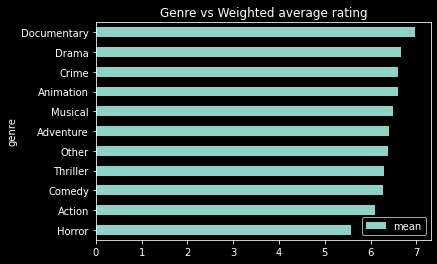

In [21]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

result.plot(kind='barh', title='Genre vs Weighted average rating')

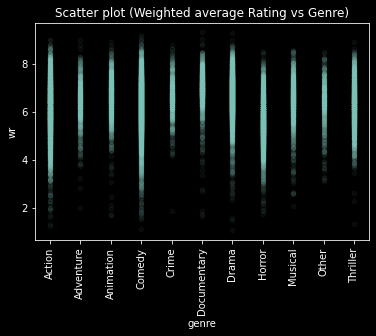

In [22]:
df.sort_values('genre').reset_index().plot(x='genre', y='wr', kind='scatter', alpha=0.05, rot=90,
                                           title='Scatter plot (Weighted average Rating vs Genre)')

# Q.2 Analysis

In [59]:
# Splits string of genres into a list of secondary and third genres.
# Or just the secondary if there are only 2 genres in the string.
# If there is only 1 genre in the string, then return empty list.
def split_series(series, genre):
  series_list = series.str.split(',')[0]
  if len(series_list) == 1:
    return ['no_info', 'no_info']
  elif len(series_list) == 2:
    series_list.remove(genre)
    return series_list + ['no_info']
  else :
    series_list.remove(genre)
    return series_list

We select all movies with 'Horror' in "genres" string and split the genres into columns "genre_2" and "genre_3".

In [60]:
test_genre = 'Horror'
t = df[df['genres'].str.contains(test_genre)].copy()
t[['genre_2', 'genre_3']] = t[['genres']].apply(split_series, axis=1, result_type='expand', genre=test_genre)

We keep only those combination of genres with count > 10.

In [61]:
t = t[t.groupby('genres').genres.transform('count') >= 10].copy()

Prepare a pivot table for a heatmap

In [62]:
result_2 = t.pivot_table(index='genre_2',columns=['genre_3'],values='wr',aggfunc=['mean'])
result_2

mean                                                   \
genre_3     Adventure    Comedy     Crime     Drama   Fantasy    Music   
genre_2                                                                  
Action       5.173265  5.559638  5.810855  5.477097  5.545208      NaN   
Adventure         NaN  5.360721       NaN  5.642003  5.524841      NaN   
Comedy            NaN       NaN  6.096358  5.909084  5.656761  5.71579   
Crime             NaN       NaN       NaN  5.973700       NaN      NaN   
Documentary       NaN       NaN       NaN       NaN       NaN      NaN   
Drama             NaN       NaN       NaN       NaN  6.070420      NaN   
Fantasy           NaN       NaN       NaN       NaN       NaN      NaN   
Mystery           NaN       NaN       NaN       NaN       NaN      NaN   
Romance           NaN       NaN       NaN       NaN       NaN      NaN   
Sci-Fi            NaN       NaN       NaN       NaN       NaN      NaN   
Thriller          NaN       NaN       NaN       NaN       NaN      NaN   
no_info           NaN       NaN       NaN       NaN       NaN      NaN   

                                                                         
genre_3       Musical   Mystery   Romance    Sci-Fi  Thriller   no_info  
genre_2                                                                  
Action            NaN  5.327824       NaN  5.307485  5.235012  5.262162  
Adventure         NaN  5.780974       NaN  5.389366  5.347941  5.655394  
Comedy       5.957432  5.810013  5.902590  5.439793  5.519071  5.491912  
Crime             NaN  5.931561       NaN  5.611132  5.560461  5.895612  
Documentary       NaN       NaN       NaN       NaN       NaN  6.161793  
Drama             NaN  5.893081  5.959734  5.956317  5.713596  6.060925  
Fantasy           NaN  5.672774       NaN  5.632274  5.435060  5.710758  
Mystery           NaN       NaN  5.773533  5.627524  5.635438  5.708736  
Romance           NaN       NaN       NaN       NaN  5.251830       NaN  
Sci-Fi            NaN       NaN       NaN       NaN  5.374324  5.359928  
Thriller          NaN       NaN       NaN       NaN       NaN  5.352246  
no_info           NaN       NaN       NaN       NaN       NaN  5.359968

# Q.2 Vizualize

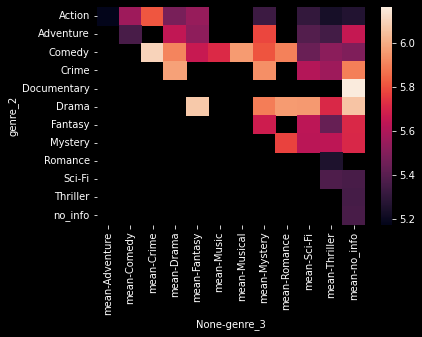

In [63]:
sns.heatmap(result_2)

# Play

In [54]:
#@title Here we can try all sorts of weird genres combinations to find a movie for the evening watch
# 'Fantasy,Horror,Romance'
t[t['genres'] == 'Drama,Fantasy,Horror'].sort_values(['startYear'], ascending=False)

,tconst,titleType,primaryTitle,startYear,genres,averageRating,numVotes,genre,wr,genre_2,genre_3
586991,tt7440124,movie,The Harbinger,2022,"Drama,Fantasy,Horror",3.7,1343.0,Horror,4.795400,Drama,Fantasy
283027,tt12519030,movie,Hatching,2022,"Drama,Fantasy,Horror",6.3,10722.0,Horror,6.297144,Drama,Fantasy
310985,tt13841850,movie,Men,2022,"Drama,Fantasy,Horror",6.1,45421.0,Horror,6.103587,Drama,Fantasy
633187,tt9812474,movie,Lamb,2021,"Drama,Fantasy,Horror",6.3,30323.0,Horror,6.298931,Drama,Fantasy
227857,tt10062338,movie,Earwig,2021,"Drama,Fantasy,Horror",5.4,1009.0,Horror,5.831321,Drama,Fantasy
...,...,...,...,...,...,...,...,...,...,...,...
9735,tt0016847,movie,Faust,1926,"Drama,Fantasy,Horror",8.1,15652.0,Horror,7.989894,Drama,Fantasy
7012,tt0013579,movie,Warning Shadows,1923,"Drama,Fantasy,Horror",6.7,1042.0,Horror,6.487719,Drama,Fantasy
5997,tt0012364,movie,The Phantom Carriage,1921,"Drama,Fantasy,Horror",8.0,13027.0,Horror,7.876419,Drama,Fantasy
6112,tt0012494,movie,Destiny,1921,"Drama,Fantasy,Horror",7.6,6257.0,Horror,7.416250,Drama,Fantasy
